<img src="assets/background_notebook.jpg" />
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2.5vw; color:#c6cde1; font-weight:bold;">
    Introduction to machine learning - Project
    </b>
</p>
<hr style="color:#c6cde1;">
<b>Introduction</b><br><br>
The purpose of this project is to design a model to predict wind power 24h ahead in 10 zones, corresponding to 10 wind farms located in Australia.<br><br>
<b>Authors</b><br><br> 
<i>Camille Bosch, Manon Cornet</i> and <i>Victor Mangeleer</i>

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Initialization
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Initialize all the librairies needed for the project;</li>
        <li style="margin-bottom:10px">Define basic functions.</li>
    </ul> 

In [1]:
# -- LIBRAIRIES --
import copy
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn import tree
from sklearn.metrics import make_scorer
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, median_absolute_error

# -- Deep Learning Librairies --
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics import R2Score

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Allow notebook to plot in terminal
%matplotlib inline

In [2]:
# -- FUNCTION --
#
# Used to print a basic section title in terminal
def section(title):

    # Number of letters to determine section size
    title_size = len(title)

    # Section title boundaries
    boundary  = "-"
    for i in range(title_size + 1):
        boundary += "-"
    
    # Printing section
    print(boundary)
    print(f" {title} ")
    print(boundary)

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Dataset - Initialization | First look
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Load the orginal datasets (X and y);</li>
        <li style="margin-bottom:10px">Observe the head of the datasets;</li>
        <li style="margin-bottom:10px">Make an histogram of the speeds;</li>
        <li style="margin-bottom:10px">Observe the total speed vs power curve;</li>
        <li style="margin-bottom:10px">Observe the evolution of the speed.</li>
    </ul> 

In [3]:
# -- LOADING ORIGINAL DATASETS --
#
# Stores the original dataset
dataset_original_X = []
dataset_original_Y = []

# Load the original dataset
for i in range(1, 11):
    dataset_original_X.append(pd.read_csv(f"data/original/X_Zone_{i}.csv"))
    dataset_original_Y.append(pd.read_csv(f"data/original/Y_Zone_{i}.csv"))

In [ ]:
# -- HEAD OF THE DATASETS --
section("WIND TURBINE 1 - X Dataset")
print(dataset_original_X[0].head())
section("WIND TURBINE 1 - Y Dataset")
print(dataset_original_Y[0].head())

In [ ]:
# -- HISTOGRAM OF THE SPEEDS --
#
# Extracting only relevant variables
dataset_X1_relevant = dataset_original_X[0][["U10", "U100", "V10", "V100"]]
dataset_Y1_relevant = dataset_original_Y[0][dataset_original_Y[0]["TARGETVAR"] >= 0]   # /!\ Removing test samples (y = -1) /!\
dataset_Y1_relevant = dataset_Y1_relevant[["TARGETVAR"]]

# Observing distributions
dataset_X1_relevant.hist(bins = 240, figsize = (20, 15))
dataset_Y1_relevant.hist(bins = 40, figsize = (16, 4))

In [ ]:
# -- OBSERVING WIND VS POWER --
#
# Removing test data
dataset_X_clean = dataset_original_X[0][dataset_original_Y[0]["TARGETVAR"] >= 0]
dataset_Y_clean = dataset_original_Y[0][dataset_original_Y[0]["TARGETVAR"] >= 0]

# Computing total wind speed
u_wind   = dataset_X_clean[["U100"]].to_numpy()
v_wind   = dataset_X_clean[["V100"]].to_numpy()
wind_tot = np.sqrt(u_wind**2 + v_wind**2)

# Retreiving power
power = dataset_Y_clean[["TARGETVAR"]].to_numpy()

# To see more clearly, one sample out of 2 is removed
for i in range(1):
    wind_tot = wind_tot[1::2]
    power    = power[1::2]

# Plotting
plt.figure(figsize=(15, 10))
plt.scatter(wind_tot, power, s = 3)
plt.grid()
plt.xlabel("Speed [m/s]")
plt.ylabel("Normalized Power [-]")
plt.show()

In [ ]:
# -- OBSERVING AUTO-CORRELATIONS --
auto_corr_plot = plot_acf(dataset_original_X[0]["U100"], lags = 30)

In [ ]:
# -- OBSERVING SPEED EVOLUTION --
#
# Retreiving first wind turbine
X_observation = dataset_original_X[0]

# Number of hours in a year
year = 8760

# Factor to scale down our timeline (f = 2, i.e. observing 6 months)
scale = 1

# Smoothening (number of values taken for averaging)
smooth = 2

# Speed to plot the evolution
speeds = ["U10"]

# ---------- Plotting ----------
# Note: Rolling allows us to average the values which "smooth out" the curve for better visibility
for s in speeds:
    X_observation.iloc[0          : int(year/scale)         ].rolling(smooth).sum().plot(y = s, use_index = True, figsize = (20, 5))
    X_observation.iloc[int(year) : int(year * (1 + 1/scale))].rolling(smooth).sum().plot(y = s, use_index = True, figsize = (20, 5), xlabel = "TimeSlice")

In [ ]:
# -- SEASONAL OBSERVATIONS --
#
# Observing seasonal evolution of an arbitrary speed
X_observation = dataset_original_X[0]["U100"]

# Coputing decomposition
seasonal_decomp = seasonal_decompose(X_observation, model = "additive", period = int(len(X_observation)/12))

# Showing evolutions
print(seasonal_decomp.plot())

[comment]: <> (Section)
<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Dataset - Modifying | DataLoader | Correlation matrix
    </b>
</p>
<hr style="color:#c6cde1;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Define functions used to modify/improve (hopefully) the datasets;</li>
        <li style="margin-bottom:10px">Define the dataloader, i.e. a custom class used to easily apply modifications to the datasets;</li>
        <li style="margin-bottom:10px">Compute and observe the correlation matrix between all possible modifications.</li>
    </ul> 
</p>



In [4]:
# -- FUNCTIONS --
#
# Used to compute the mean and variance of a variable over some timeslices (number defined by the window size) in the dataset
def computeMeanVariance(datasets, 
                        variables = ["U100", "V100"],
                        window    = 24,
                        variance  = True):

    # Security
    assert window > 1, "Window size must be greater than 1 to compute mean and var"

    # Looping over all the datasets
    for d in datasets:

        # Looping over the variables whose mean and var must be computed
        for v in variables:

            # Retreiving data 
            data = d.loc[: , [v]].to_numpy()

            # Stores mean and variance (1st and 2nd : mean = their value, var = 0 otherwise NAN problem while computation)
            mean = [data[0][0], data[1][0]]
            var  = [0, 0]

            for i in range(2, len(data)):

                # Start and end index for computation
                index_start = i - window if i - window >= 0 else 0
                index_end   = i - 1 if i - 1 >= 0 else 0

                # Computing mean and variance (much faster using numpy variables)
                mean.append(np.mean(data[index_start:index_end]))
                var.append(np.var(data[index_start:index_end]))
            
            # Adding the new data to dataset
            d[f"{v}_mean"] = mean
            if variance:
                d[f"{v}_var"] = var

# Used to compute the instantenous mean and variance of a variable accross multiple datasets
def computeZonalValue(datasets, 
                      variables = ["U100", "V100"],
                      variance  = True):

    # Security
    assert len(datasets) > 1, "To compute mean and var, at least 2 datasets are needed"

    # Looping over the variables whose mean and var must be computed
    for v in variables:

        # Number of samples
        nb_samples = len(datasets[0])

        # Stores all the different values in numpy matrix for efficient computation
        data = np.zeros((nb_samples, len(datasets)))

        # Retreiving all the corresponding data
        for i, d in enumerate(datasets):
            
            # Squeeze is there to remove useless dimension
            data[:, i] = np.squeeze(d.loc[: , [v]].to_numpy())

        # Computing mean and variance (much faster using numpy variables)
        mean = np.mean(data, axis = 1) # Axis = 1 to make mean over each row
        var  = np.var(data, axis = 1)

        # Adding new data to all the datasets
        for d in datasets:
            d[f"{v}_mean"] = mean
            if variance:
                d[f"{v}_var"] = var

# Used to add the value taken by a given variable over the past samples
def addPastTime(datasets,
                variables = ["U100", "V100"],
                window    = 3):

    # Security
    assert window > 0, "Window size must be greater than 0 to add past samples"

    # Looping over the datasets
    for d in datasets:

        # Looping over the different columns
        for i, v in enumerate(variables):

            # Retrieving current data
            data = d[[v]].to_numpy()

            # Stores all the past results
            former_data = np.zeros((len(data), window))

            # Looping over the corresponding data
            for j in range(len(data)):

                # Start and end index for retreiving values
                index_start = j - window if j - window >= 0 else 0
                index_end   = j if j - 1 >= 0 else 0
                
                # Retrieve corresponding value
                values = data[index_start:index_end]

                # Fixing case where looking at starting indexes < window size
                if len(values) != window:
                    values = np.append(np.zeros((window - len(values), 1)), values)

                # Placing the data (such that by reading left to right: t - 1, t - 2, t - 3, ...)
                for k, val in enumerate(values):
                        former_data[j][k] = val

            # Addding past results in the dataset
            for t in range(window):
                d[f"{v}_(t-{window - t})"] = former_data[:, t]

# Used to remove specific columns from the dataset
def remove(datasets, var_removed):
    for d in datasets:
        for v in var_removed:
            d.drop(v, inplace = True, axis = 1)

# Used to normalize specific columns from the dataset
def normalize(datasets,
              norm_type = "max_abs",
              data_type = "column",
              variables = ["U10", "V10", "U100", "V100"]):

    # Security
    assert norm_type in ["max_abs", "standard", "robust"], "Normalization type = max_abs, standard and robust"
    assert data_type in ["column", "all"],                 "Data type = column, all"

    # Normalization by columns
    if data_type == "column":

        # Looping overall the datasets
        for d in datasets:

            # Current data
            data = d[variables].to_numpy()

            # Normalization
            if norm_type == "max_abs":
                scaled_features = MaxAbsScaler().fit_transform(data)
            elif norm_type == "standard":
                scaled_features = StandardScaler().fit_transform(data)
            elif norm_type == "robust":
                scaled_features = RobustScaler().fit_transform(data)

            # Updating values
            d[variables] = scaled_features

    # Normalization on the whole dataset
    elif data_type == "all":

        # Concatenation of all the dataset for the sake of simplicity
        data = pd.concat(datasets, keys=[i for i in range(len(datasets))])

        # Current data
        data_np = data[variables].to_numpy()

        # Normalization
        if norm_type == "max_abs":
            scaled_features = MaxAbsScaler().fit_transform(data_np)
        elif norm_type == "standard":
            scaled_features = StandardScaler().fit_transform(data_np)
        elif norm_type == "robust":
            scaled_features = RobustScaler().fit_transform(data_np)

        # Updating values
        data[variables] = scaled_features

        # Re-creation of the datasets
        for i in range(len(datasets)):
            datasets[i] = data.loc[i, :]

# Used to retrieve the wind direction and the wind speed from meridional and zonal comp. and add them in the dataset
def wind_comp(datasets, 
              columns      = "both", 
              speed_height = "both"):

    # Security
    assert columns in ["wind_speed", "wind_direction", "both"], "Columns      = wind_speed, wind_direction or both"
    assert speed_height in ["10", "100", "both"],               "Speed height = 10, 100 or both"

    # Find the speed speed and the wind direction
    for d in datasets:

        # Computing speed at 10 meters from th ground
        if speed_height in ["10", "both"]:
            w_u_10 = d["U10"].to_numpy()
            w_v_10 = d["V10"].to_numpy()

            if columns in ["wind_speed", "both"]:
                d["WS10"] = np.sqrt(np.square(w_u_10) + np.square(w_v_10))
            if columns in ["wind_direction", "both"]:
                d["WS10_angle"] = np.arctan2(w_v_10, w_u_10)

        # Computing speed at 100 meters from th ground
        if speed_height in ["100", "both"]:
            w_u_100 = d["U100"].to_numpy()
            w_v_100 = d["V100"].to_numpy()

            if columns in ["wind_speed", "both"]:
                d["WS100"] = np.sqrt(np.square(w_u_100) + np.square(w_v_100))
            if columns in ["wind_direction", "both"]:
                d["WS100_angle"] = np.arctan2(w_v_100, w_u_100)

In [5]:
# -- DATA LOADER -- 
#
class dataLoader():
    
    # Initialization of the loader
    def __init__(self, datasets_X, datasets_Y):

        # Stores the original, transformed and final datasets
        self.original_datasets_X    = datasets_X
        self.original_datasets_Y    = datasets_Y
        self.transformed_datasets_X = datasets_X
        self.transformed_datasets_Y = datasets_Y
        self.final_dataset_X        = None
        self.final_dataset_Y        = None

        # Used to know if datasets have been combined or not
        self.isCombined = None

    # Used to display the head of the transformed dataset (first set)
    def showHeadTransformed(self):
        section("Dataset - X - Transformed")
        print(self.transformed_datasets_X[0].head())
        section("Dataset - Y - Transformed")
        print(self.transformed_datasets_Y[0].head())

    # Used to split the final dataset into a train and test set (In test set, values for y are equal to -1)
    def splitTrainTest(self, save = False, save_dir = "new_data"):

        # Security
        assert self.isCombined != None, "You must first use self.finalize"

        # Case 1 - Datasets have been combined all together
        if self.isCombined == True:
            X_train = self.final_dataset_X[self.final_dataset_Y['TARGETVAR'] != -1]
            Y_train = self.final_dataset_Y[self.final_dataset_Y['TARGETVAR'] != -1]
            X_test  = self.final_dataset_X[self.final_dataset_Y['TARGETVAR'] == -1]
            Y_test  = self.final_dataset_Y[self.final_dataset_Y['TARGETVAR'] == -1] # Not useful, I know !

        # Case 2 - Datasets are still separated
        if self.isCombined == False:
            
            X_train, Y_train, X_test, Y_test = list(), list(), list(), list()

            # Looping over all the small datasets
            for x, y in zip(self.final_dataset_X, self.final_dataset_Y):
                X_train.append(x[y['TARGETVAR'] != -1])
                Y_train.append(y[y['TARGETVAR'] != -1])
                X_test.append(x[y['TARGETVAR'] == -1])
                Y_test.append(y[y['TARGETVAR'] == -1])

        # Be careful with the order
        return X_train, X_test, Y_train, Y_test
        
    # Used to perfom final operation on dataset (Combining everything or storing them separately)
    def finalization(self, dataset_type = "combined"):

        # Security
        assert dataset_type in ["combined", "separated"], "The final dataset can either be of type combined or separated"

        # Case 1 - Combining into one big dataset
        if dataset_type == "combined":
            self.final_dataset_X = pd.concat(self.transformed_datasets_X)
            self.final_dataset_Y = pd.concat(self.transformed_datasets_Y)
            self.isCombined = True

        # Case 2 - Separated datasets
        else:
            self.final_dataset_X = self.transformed_datasets_X
            self.final_dataset_Y = self.transformed_datasets_Y
            self.isCombined = False

    #-----------------------------------------------------------------------------------------------------------------------------------
    #                                                               PIPELINE
    #-----------------------------------------------------------------------------------------------------------------------------------
    def pipeline(self, useMeanVariance   = True,  var_MV   = ["U10", "V10", "U100", "V100"], variance_MV  = True, window_MV = 24 * 7,
                       useZonal          = True,  var_ZON  = ["U10", "V10", "U100", "V100"], variance_ZON = True,
                       usePastTime       = True,  var_PT   = ["U10", "V10", "U100", "V100"], window_ZON   = 3,
                       useNormalize      = True,  var_NORM = ["U10", "V10", "U100", "V100"], norm_type = "max_abs", data_type = "column",
                       useSpeedNorm      = True,  SpeedNorm_height = "both",
                       useSpeedDirection = True,  SpeedDir_height  = "both",
                       removing          = False, var_removed      = ["U10", "V10", "U100", "V100"]):

        # Copying original dataset
        dX = copy.deepcopy(self.original_datasets_X)
        dY = copy.deepcopy(self.original_datasets_Y)

        # Applying the different transformations
        if useNormalize:
            normalize(dX, variables = var_NORM, norm_type = norm_type, data_type = data_type)
        if useSpeedNorm:
            wind_comp(dX, columns = "wind_speed",     speed_height = SpeedNorm_height)
        if useSpeedDirection:
            wind_comp(dX, columns = "wind_direction", speed_height = SpeedDir_height)
        if useMeanVariance:
            computeMeanVariance(dX, variables = var_MV, window = window_MV, variance = variance_MV)
        if useZonal:
            computeZonalValue(dX, variables = var_ZON, variance = variance_ZON)
        if usePastTime:
            addPastTime(dX, variables = var_PT, window = window_ZON)
        if removing:
            remove(dX, variables = var_removed)
        
        # Updating dataset
        self.transformed_datasets_X = dX
        self.transformed_datasets_Y = dY

        # Making sure one has to finalize again
        self.isCombined = None

In [ ]:
# -- CORRELATION MATRIX -- 
#
# Define which correlation matrix to compute
nb_correlation = 1

# Used to plot correlation matrix
def plotCorrelationMatrix(loader, treshold = 0.3, color = "YlGnBu", number = 1):

    # Finalization of the loader
    loader.finalization(dataset_type = "combined")
    
    # Retreives the train and test set (in Pandas frame)
    data_X, _, _, _ = loader.splitTrainTest()

    # Plotting correlation matrix, removing low values, changing plot color
    corr             = data_X.corr()
    corr[np.abs(corr) < treshold] = 0
    sns.set(rc={'figure.figsize':(25, 20)})
    sns.heatmap(corr, cmap = color, annot = True)
    plt.savefig(f"graphs/correlation/correlation_matrix_{number}.png")

# Initialization of the loader
loader = dataLoader(dataset_original_X, dataset_original_Y)

# Plotting
if nb_correlation == 1:
    loader.pipeline(norm_type = "max_abs", data_type = "all")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 1)
elif nb_correlation == 2:
    loader.pipeline(norm_type = "standard", data_type = "all")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 2)
elif nb_correlation == 3:
    loader.pipeline(norm_type = "robust", data_type = "all")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 3)
elif nb_correlation == 4:
    loader.pipeline(norm_type = "max_abs", data_type = "column")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 4)
elif nb_correlation == 5:
    loader.pipeline(norm_type = "standard", data_type = "column")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 5)
else:
    loader.pipeline(norm_type = "robust", data_type = "column")
    plotCorrelationMatrix(loader, treshold = 0.3, number = 6)

[comment]: <> (Section)
<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Dataset - Generation
    </b>
</p>
<hr style="color:#c6cde1;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to generate and store all the different datasets that will be tested by the different methods:
    <ol>
        <li style="margin-bottom:10px">MeanVariance : window = 3, window = 12, window = 24</li>
        <li style="margin-bottom:10px">ZonalMean</li>
        <li style="margin-bottom:10px">PastTime     : window = 1, window = 2,  window = 3</li>
        <li style="margin-bottom:10px">SpeedNorm</li>
        <li style="margin-bottom:10px">SpeedDir</li>
    </ol> 
</p>


In [15]:
# Define which datasets will be compared to one another
dataset_choice = [1, 2, 3, 4, 5]

# Define the type of dataset ("combined" or "separated")
dt = "combined"

# Define which zone you want the dataset from (only works if dt = "seprated")
zone_id = 1 if dt == "separated" else 0

# Normalization parameters
norm_parameters = ["standard", "all"]

# Define the different window tested by the MeanVariance
window_MV = [3, 12, 24]

# Define the different window tested by the PastTime
window_PT = [1, 2, 3]

In [ ]:
# -- TEMPLATE --
"""
loader.pipeline(useMeanVariance    = True,  var_MV   = ["U10", "V10", "U100", "V100"], variance_MV  = True, window_MV = 24 * 7,
                useZonal           = True,  var_ZON  = ["U10", "V10", "U100", "V100"], variance_ZON = True,
                usePastTime        = True,  var_PT   = ["U10", "V10", "U100", "V100"], window_ZON   = 3,
                useNormalize       = True,  var_NORM = ["U10", "V10", "U100", "V100"], norm_type = "max_abs", data_type = "column",
                useSpeedNorm       = True,  SpeedNorm_height = "both",
                useSpeedDirection  = True,  SpeedDir_height  = "both",
                removing           = False, var_removed      = ["U10", "V10", "U100", "V100"])
"""

In [16]:
# -- GENERATION OF THE DATASETS --
#
# Stores all the newly generated datasets
datasets_X, datasets_X_submit, datasets_Y, datasets_Y_submit = list(), list(), list(), list()

# Intialization of the loader
loader = dataLoader(dataset_original_X, dataset_original_Y)

# Displaying information over terminal (1)
print("Generating : ...")

# Retrieving the index of the zone considered
index_zone = zone_id - 1

# 0 - Originals
loader.pipeline(useMeanVariance    = False,
                useZonal           = False,
                usePastTime        = False,
                useNormalize       = False,
                useSpeedNorm       = False,
                useSpeedDirection  = False,
                removing           = False)
loader.finalization(dataset_type = dt)

# Creation of datasets
X, submit_X, Y, submit_Y = loader.splitTrainTest()

# Adding all the datasets
datasets_X.append(       X[index_zone]        if dt == "separated" else X)
datasets_Y.append(       Y[index_zone]        if dt == "separated" else Y)
datasets_X_submit.append(submit_X[index_zone] if dt == "separated" else submit_X) 
datasets_Y_submit.append(submit_Y[index_zone] if dt == "separated" else submit_Y)

# 1 - MeanVariance
if 1 in dataset_choice:
    for w in window_MV:
        loader.pipeline(useMeanVariance    = True, var_MV   = ["U10", "V10", "U100", "V100"], variance_MV  = True, window_MV = w,
                        useZonal           = False,
                        usePastTime        = False,
                        useNormalize       = True, norm_type = norm_parameters[0], data_type = norm_parameters[1],
                        useSpeedNorm       = False,
                        useSpeedDirection  = False,
                        removing           = False)
        loader.finalization(dataset_type = dt)

        # Creation of datasets
        X, submit_X, Y, submit_Y = loader.splitTrainTest()

        # Adding all the datasets
        datasets_X.append(       X[index_zone]        if dt == "separated" else X)
        datasets_Y.append(       Y[index_zone]        if dt == "separated" else Y)
        datasets_X_submit.append(submit_X[index_zone] if dt == "separated" else submit_X) 
        datasets_Y_submit.append(submit_Y[index_zone] if dt == "separated" else submit_Y)

# 2 - ZonalMean
if 2 in dataset_choice:
    loader.pipeline(useMeanVariance    = False,
                    useZonal           = True, var_ZON  = ["U10", "V10", "U100", "V100"], variance_ZON = True,
                    usePastTime        = False,
                    useNormalize       = True, norm_type = norm_parameters[0], data_type = norm_parameters[1],
                    useSpeedNorm       = False,
                    useSpeedDirection  = False,
                    removing           = False)
    loader.finalization(dataset_type = dt)

    # Creation of datasets
    X, submit_X, Y, submit_Y = loader.splitTrainTest()

    # Adding all the datasets
    datasets_X.append(       X[index_zone]        if dt == "separated" else X)
    datasets_Y.append(       Y[index_zone]        if dt == "separated" else Y)
    datasets_X_submit.append(submit_X[index_zone] if dt == "separated" else submit_X) 
    datasets_Y_submit.append(submit_Y[index_zone] if dt == "separated" else submit_Y)


# 3 - PastTime
if 3 in dataset_choice:
    for w in window_PT:
        loader.pipeline(useMeanVariance    = False,
                        useZonal           = False,
                        usePastTime        = True, var_PT   = ["U10", "V10", "U100", "V100"], window_ZON = w,
                        useNormalize       = True, norm_type = norm_parameters[0], data_type = norm_parameters[1],
                        useSpeedNorm       = False,
                        useSpeedDirection  = False,
                        removing           = False)
        loader.finalization(dataset_type = dt)

        # Creation of datasets
        X, submit_X, Y, submit_Y = loader.splitTrainTest()

        # Adding all the datasets
        datasets_X.append(       X[index_zone]        if dt == "separated" else X)
        datasets_Y.append(       Y[index_zone]        if dt == "separated" else Y)
        datasets_X_submit.append(submit_X[index_zone] if dt == "separated" else submit_X) 
        datasets_Y_submit.append(submit_Y[index_zone] if dt == "separated" else submit_Y)


# 4 - SpeedNorm
if 4 in dataset_choice:
    loader.pipeline(useMeanVariance    = False,
                    useZonal           = False,
                    usePastTime        = False,
                    useNormalize       = True, norm_type = norm_parameters[0], data_type = norm_parameters[1],
                    useSpeedNorm       = True, SpeedNorm_height = "both",
                    useSpeedDirection  = False,
                    removing           = False)
    loader.finalization(dataset_type = dt)

    # Creation of datasets
    X, submit_X, Y, submit_Y = loader.splitTrainTest()

    # Adding all the datasets
    datasets_X.append(       X[index_zone]        if dt == "separated" else X)
    datasets_Y.append(       Y[index_zone]        if dt == "separated" else Y)
    datasets_X_submit.append(submit_X[index_zone] if dt == "separated" else submit_X) 
    datasets_Y_submit.append(submit_Y[index_zone] if dt == "separated" else submit_Y)


# 5 - SpeedDir
if 5 in dataset_choice:
    loader.pipeline(useMeanVariance    = False,
                    useZonal           = False,
                    usePastTime        = False,
                    useNormalize       = True, norm_type = norm_parameters[0], data_type = norm_parameters[1],
                    useSpeedNorm       = False,
                    useSpeedDirection  = True, SpeedDir_height  = "both",
                    removing           = False)
    loader.finalization(dataset_type = dt)

    # Creation of datasets
    X, submit_X, Y, submit_Y = loader.splitTrainTest()

    # Adding all the datasets
    datasets_X.append(       X[index_zone]        if dt == "separated" else X)
    datasets_Y.append(       Y[index_zone]        if dt == "separated" else Y)
    datasets_X_submit.append(submit_X[index_zone] if dt == "separated" else submit_X) 
    datasets_Y_submit.append(submit_Y[index_zone] if dt == "separated" else submit_Y)

# Displaying information over terminal (2)
print("Generating : Done")
print(f"Number of generated datasets: {len(datasets_X)}")

Generating : ...
Generating : Done
Number of generated datasets: 10


[comment]: <> (Section)
<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Model - Pre-Classifier
    </b>
</p>
<hr style="color:#c6cde1;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Trained a model to pre-classify the data (wether or not, power is created with wind conditions);</li>
        <li style="margin-bottom:10px">Observe a custom class "ModelEnsemble" which allow to create a model resulting from the combination of the pre-classifier and a trained model.</li>
    </ul> 
</p>

In [ ]:
# -- ENSEMBLE MODEL --
#
# The goal of this class is to create our own predict function which is composed of 2 main steps:
# - The pre-classifier's determines whether or not the wind is sufficiently high to have a power creation
# - The model which predicts the power creation
class ModelEnsemble():

    # Initialization of the ensemble model
    def __init__(self, model_prec_classifier, model_trained):
        self.pre_classifier = model_prec_classifier
        self.trained        = model_trained 
    
    # Used to compute predictions
    def predict(self, x, predict_treshold = 0.95):

        # 1 - Determining if there is power or not 
        PC_results  = self.pre_classifier.predict_proba(x)

        # 2 - Power predictions
        MOD_results = self.trained.predict(x)

        # 3 - Replacing predictions with pre-classifier results 
        for i, r in enumerate(PC_results):
            MOD_results[i] = 0 if r[0] > predict_treshold else MOD_results[i]

        return MOD_results

In [ ]:
# -- PRE-CLASSIFIER'S DATASET --
# 
# Creation of the special dataset for training the pre-classifier
dataset_X_preclassifier = copy.deepcopy(datasets_X[0])
dataset_Y_preclassifier = copy.deepcopy(datasets_Y[0])

# Transforming into binary classification problem (0 = no power, 1 = power to predict)
dataset_Y_preclassifier[dataset_Y_preclassifier["TARGETVAR"] != 0] = 1
dataset_X_preclassifier                                            = dataset_X_preclassifier.to_numpy()
dataset_Y_preclassifier                                            = dataset_Y_preclassifier["TARGETVAR"].to_numpy()

# Retreiving train and test sets
X_PRE_train, X_PRE_test, y_PRE_train, y_PRE_test = train_test_split(dataset_X_preclassifier, dataset_Y_preclassifier, test_size = 0.3, random_state = 69)

In [ ]:
# -- TRAINING AND TESTING OF THE PRE-CLASSIFIER -- 
#
# Definition of the parameters that will be tested
GS_param_dt  = {'max_depth'   : [i for i in range(7, 13)]}

# Initialization of the model
model_pre_classifier = GridSearchCV(tree.DecisionTreeClassifier(), GS_param_dt)

# Finding the best parameter
model_pre_classifier.fit(X_PRE_train, y_PRE_train)

# Computing final accuracy 
accuracy_pre_classifier = model_pre_classifier.score(X_PRE_test, y_PRE_test)

# Display information over terminal (1)
section("Results")
print(f"Pre classifier's accuracy [%] : {accuracy_pre_classifier * 100}")
print(model_pre_classifier.best_params_)

[comment]: <> (Section)
<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Model - Training | Testing | Plotting results per Zone
    </b>
</p>
<hr style="color:#c6cde1;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Find functions to plot easily compare accuracy results of a method against each dataset.</li>
    </ul> 
</p>

In [10]:
# -- ERROR COMPUTATION --
#
# Found from : https://github.com/smazzanti
#
def _yield_pairs(y_true, num_rounds):
  """
  Returns pairs of valid indices. Indices must belong to observations having different values.
  
  Parameters:
  ----------
  y_true     : array-like of shape (n_samples,). Binary or continuous target variable.
  num_rounds : int or string. If integer, number of random pairs of observations to return. 
               If string, 'exact', all possible pairs of observations will be returned.
  
  Yields:
  -------
  i, j: tuple of int of shape (2,). Indices referred to a pair of samples.
  """
  if num_rounds == 'exact':
    for i in range(len(y_true)):
      for j in np.where((y_true != y_true[i]) & (np.arange(len(y_true)) > i))[0]:
        yield i, j     
  else:
    for r in range(num_rounds):
      i = np.random.choice(range(len(y_true)))
      j = np.random.choice(np.where(y_true != y_true[i])[0])
      yield i, j

def regression_roc_auc_score(y_true, y_pred, num_rounds = 10000):
  """
  Computes Regression-ROC-AUC-score.
  
  Parameters:
  ----------
  y_true     : array-like of shape (n_samples,). Binary or continuous target variable.
  y_pred     : array-like of shape (n_samples,). Target scores.
  num_rounds : int or string. If integer, number of random pairs of observations. 
               If string, 'exact', all possible pairs of observations will be evaluated.
  
  Returns:
  -------
  rroc: float. Regression-ROC-AUC-score.
  """
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  num_pairs     = 0
  num_same_sign = 0
  
  for i, j in _yield_pairs(y_true, num_rounds):
    diff_true  = y_true[i] - y_true[j]
    diff_score = y_pred[i] - y_pred[j]

    if diff_true * diff_score > 0:
      num_same_sign += 1
    elif diff_score == 0:
      num_same_sign += .5
    num_pairs += 1
      
  return num_same_sign / num_pairs

def computeError(n_y_true, n_y_pred):
    """
    Compute the error to evaluate the performance of the model 

    Parameters
    -----------
    n_y_true: list of np.array
              Ground truth (correct) target values.


    n_y_pred: list of np.array 
              Estimated target values.
    
   
    """
    mae, rmse, mdae, r2, auc = [], [], [], [], []

    for y_true, y_pred in zip(n_y_true, n_y_pred):
        mae.append(mean_absolute_error(y_true, y_pred))
        rmse.append(mean_squared_error(y_true, y_pred, squared = False))
        mdae.append(median_absolute_error(y_true, y_pred))

        r2.append(r2_score(y_true, y_pred))
        auc.append(regression_roc_auc_score(y_true, y_pred, num_rounds = 1000))

    return mae, rmse, mdae, r2, auc

In [11]:
# -- FUNCTIONS --
#
# Used to compute a model's accuracy against different datasets
def modelTesting(datasets_X, datasets_y, model, test_size = 0.3, random_state = 69):
    
    # Contains mean accuracy of the model against each dataset
    accuracy_train, accuracy_test, y_true, y_pred = list(), list(), list(), list()

    # Looping over whole the different datasets
    for X, y in zip(datasets_X, datasets_y):
        
        # Final conversion (Numpy and retrieving targets)
        X = X.to_numpy()
        y = y[["TARGETVAR"]].to_numpy().ravel()

        # Retrieving datasets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

        # Fitting the model on current split
        model.fit(X_train, y_train)

        # Prediction 
        y_pred.append(model.predict(X_test))
        y_true.append(y_test)

        # Accuracy
        accuracy_train.append(model.score(X_train, y_train))
        accuracy_test.append(model.score(X_test, y_test))

    return accuracy_train, accuracy_test, y_pred, y_true 

# Used to determine the best parameter and the associated dataset
def computeBest (parameters, acc_train, acc_test, y_pred, y_true):

    # Used to store the best results
    acc_test_best, acc_train_best = [], []
    y_pred_best,  y_true_best     = [], []
    param_best                    = []

    # Looping over accuracies to find best results
    for a1, a2, y1, y2 in zip(acc_train, acc_test, y_pred, y_true):

        # Finding best test accuracy
        max_value = max(a2)
        max_index = a2.index(max_value)

        # Adding results
        acc_test_best.append(max_value)
        acc_train_best.append(a1[max_index])
        y_pred_best.append(y1[max_index])
        y_true_best.append(y2[max_index])
        param_best.append(parameters[max_index])

    return acc_test_best, acc_train_best, y_pred_best, y_true_best, param_best

# Used to compare the accuracy of a model against each dataset
def modelPlotResults(parameters, acc_train, acc_test, y_pred, y_true, 
                     xlabel, param_name, fontsize = 15, save_path = "graphs/", evolution_param = True):

    # Chaging overall font scale
    sns.set(font_scale = 1.1)
    
    # In some cases, like for linear regression, there is no parameter to make evoluate
    if evolution_param:

        # 1 - Evolution of the test accuracy
        plt.figure(figsize = (15, 15))

        # Plotting evolution curve for a specific dataset with varying parameter value
        for i, a in enumerate(acc_test):
            plt.plot(parameters, [a_i * 100 for a_i in a], label = f"D{i}", linewidth = 4)
        
        plt.legend(loc="upper left", fontsize = fontsize)
        plt.ylabel("Accuracy [%]", fontsize = fontsize)
        plt.xlabel(xlabel, fontsize = fontsize)
        plt.savefig(f"{save_path}_1.png")
        plt.show()
   
        acc_test_best, acc_train_best, y_pred_best, y_true_best, k_best = computeBest(parameters, 
                                                                                      acc_train, 
                                                                                      acc_test, 
                                                                                      y_pred, 
                                                                                      y_true)
                                      
        # Definition of the xlabel for the bar plot
        x_ax_labels_1 = [f"D{i} - {param_name} = {k_best[i]}" for i in range(len(acc_train))]
        x_ax_labels_2 = [f"D{i} - {param_name} = {k_best[i]}" for i in range (len(y_pred))]

    else:
        x_ax_labels_1 = [f"D{i}" for i in range(len(acc_train))]
        x_ax_labels_2 = [f"D{i}" for i in range (len(y_pred))]
        acc_test_best, acc_train_best = acc_test, acc_train
        y_pred_best, y_true_best      = y_pred, y_true 

    # 2 - Bar plot of accuracy 
    index = [i for i in range(len(acc_train))]

    # Plotting the results
    plt.figure(figsize = (20, 7))
    plt.bar([i - 0.2 for i in index], [a_i * 100 for a_i in acc_train_best], 0.4, label = "Train")
    plt.bar([i + 0.2 for i in index], [a_i * 100 for a_i in acc_test_best ], 0.4, label = "Test")
    plt.legend(loc="upper left", fontsize = fontsize)
    plt.xticks(index, x_ax_labels_1)
    plt.ylabel("Accuracy [%]", fontsize = fontsize)
    plt.savefig(f"{save_path}_2.png")
    plt.show()
    
    # 3 - Bar plot of different errors and accuracy measurements
    mae, rmse, mdae, r2, auc = [], [], [], [], []
    mae, rmse, mdae, r2, auc = computeError(y_true_best, y_pred_best)
  
    # Used to make x-axis
    index = [i for i in range(len(y_pred))]
    
    # Plotting the results
    plt.figure(figsize = (20, 12))
    plt.subplot(211)
    plt.bar([i - 0.2 for i in index], [mae_i *100 for mae_i in mae],     0.2, label = "Mean Absolute Error")
    plt.bar([i   for i in index],     [rmse_i *100  for rmse_i in rmse], 0.2, label = "Root Mean Squared Error")
    plt.bar([i + 0.2 for i in index], [mdae_i  *100 for mdae_i in mdae], 0.2, label = "Median Absolute Error")
    plt.ylabel("Error [%] ", fontsize = fontsize)
    plt.xticks(index, x_ax_labels_2)
    plt.legend(loc="upper left", fontsize = fontsize)
    plt.subplot(212)
    plt.bar([i - 0.1 for i in index], [r2_i * 100 for r2_i in r2],    0.2, label = "R2 Score")
    plt.bar([i + 0.1 for i in index], [auc_i * 100 for auc_i in auc], 0.2, label = "AUC")
    plt.ylabel("Measurement [%] ", fontsize = fontsize)
    plt.xticks(index, x_ax_labels_2)
    plt.legend(loc="upper left", fontsize = fontsize)
    plt.savefig(f"{save_path}_Error.png")
    plt.show()

# Used to compare the accuracy of a model against each others (adaptation for complex models)
def modelPlotResultsComplex(y_pred, y_true, xlabels, fontsize = 15, save_path = "graphs/"):

    # Security
    assert len(y_pred) == len(y_true),  f"Number of predictions = {len(y_pred)},  Number of exact measurements = {len(y_true)}"
    assert len(y_pred) == len(xlabels), f"Number of predictions = {len(y_pred)}, Number of labels             = {len(xlabels)}"

    # Stores the differents errors and accuracy measurements
    mae, rmse, mdae, r2, auc = list(), list(), list(), list(), list()

    # Computing everything
    mae, rmse, mdae, r2, auc = computeError(y_true, y_pred)

    # Used to make x-axis
    index = [i for i in range(len(y_pred))]
    
    # Plotting the results
    sns.set(font_scale = 1.1)
    plt.figure(figsize = (20, 12))
    plt.subplot(211)
    plt.bar([i - 0.2 for i in index], [mae_i *100 for mae_i in mae]    , 0.2, label = "Mean Absolute Error")
    plt.bar([i   for i in index],     [rmse_i *100  for rmse_i in rmse], 0.2, label = "Root Mean Squared Error")
    plt.bar([i + 0.2 for i in index], [mdae_i  *100 for mdae_i in mdae], 0.2, label = "Median Absolute Error")
    plt.ylabel("Error [%] ", fontsize = fontsize)
    plt.xticks(index, xlabels)
    plt.legend(loc = "upper left", fontsize = fontsize)

    plt.subplot(212)
    plt.bar([i - 0.1 for i in index], [r2_i * 100 for r2_i in r2],    0.2, label = "R2 Score")
    plt.bar([i + 0.1 for i in index], [auc_i * 100 for auc_i in auc], 0.2, label = "AUC")
    plt.ylabel("Measurement [%] ", fontsize = fontsize)
    plt.xticks(index, xlabels)
    plt.legend(loc="upper left", fontsize = fontsize)
    plt.savefig(f"{save_path}_Error.png")
    plt.show()

In [12]:
# -- OTHERS --
#
# Used to display a simple progress bar while training for 1 epoch
def progressBar(loss_training, loss_test, r2_test, estimated_time_epoch, nb_epoch_left, percent, width = 40):

    # Setting up the useful information
    left          = width * percent // 100
    right         = width - left
    tags          = "#" * int(left)
    spaces        = " " * int(right)
    percents      = f"{percent:.2f} %"
    loss_training = f"{loss_training * 1:.4f}"
    loss_test     = f"{loss_test * 1:.4f}"
    r2_test       = f"{r2_test * 100 * 1:.4f}"

    # Computing timings
    estimated_time_total = f"{nb_epoch_left * estimated_time_epoch:.2f} s"

    # Creation of the string
    bar = f"[{tags}{spaces}] - {percents}  | Loss (Training) = {loss_training} | Loss (Test) = {loss_test} | R2 Metric [%] = {r2_test} | Time left : {estimated_time_total} |"

    # Displaying the progress bar
    print(bar, end = "\r", flush = True)

<hr style="color:#c6cde1; width: 187px;" align="left">
<p style="color:#c6cde1;">Linear Regression (Example)</p>
<hr style="color:#c6cde1; width: 187px;" align="left">


In [17]:
# -- TRAINING AND TESTING -- 
#
# Initialization of the model
model = LinearRegression()

# Computing accuracies
lr_accuracy_train, lr_accuracy_test, lr_y_pred, lr_y_true = modelTesting(datasets_X, datasets_Y, model, test_size = 0.3, random_state = 69) 

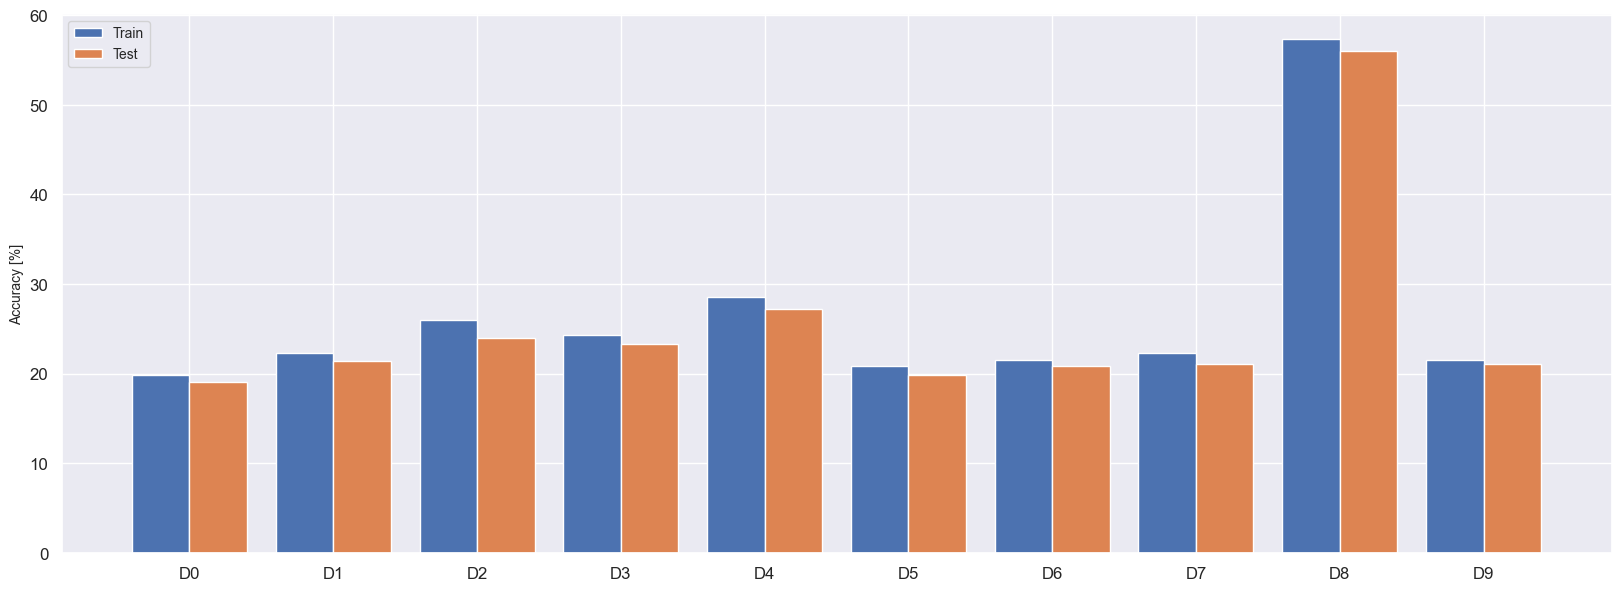

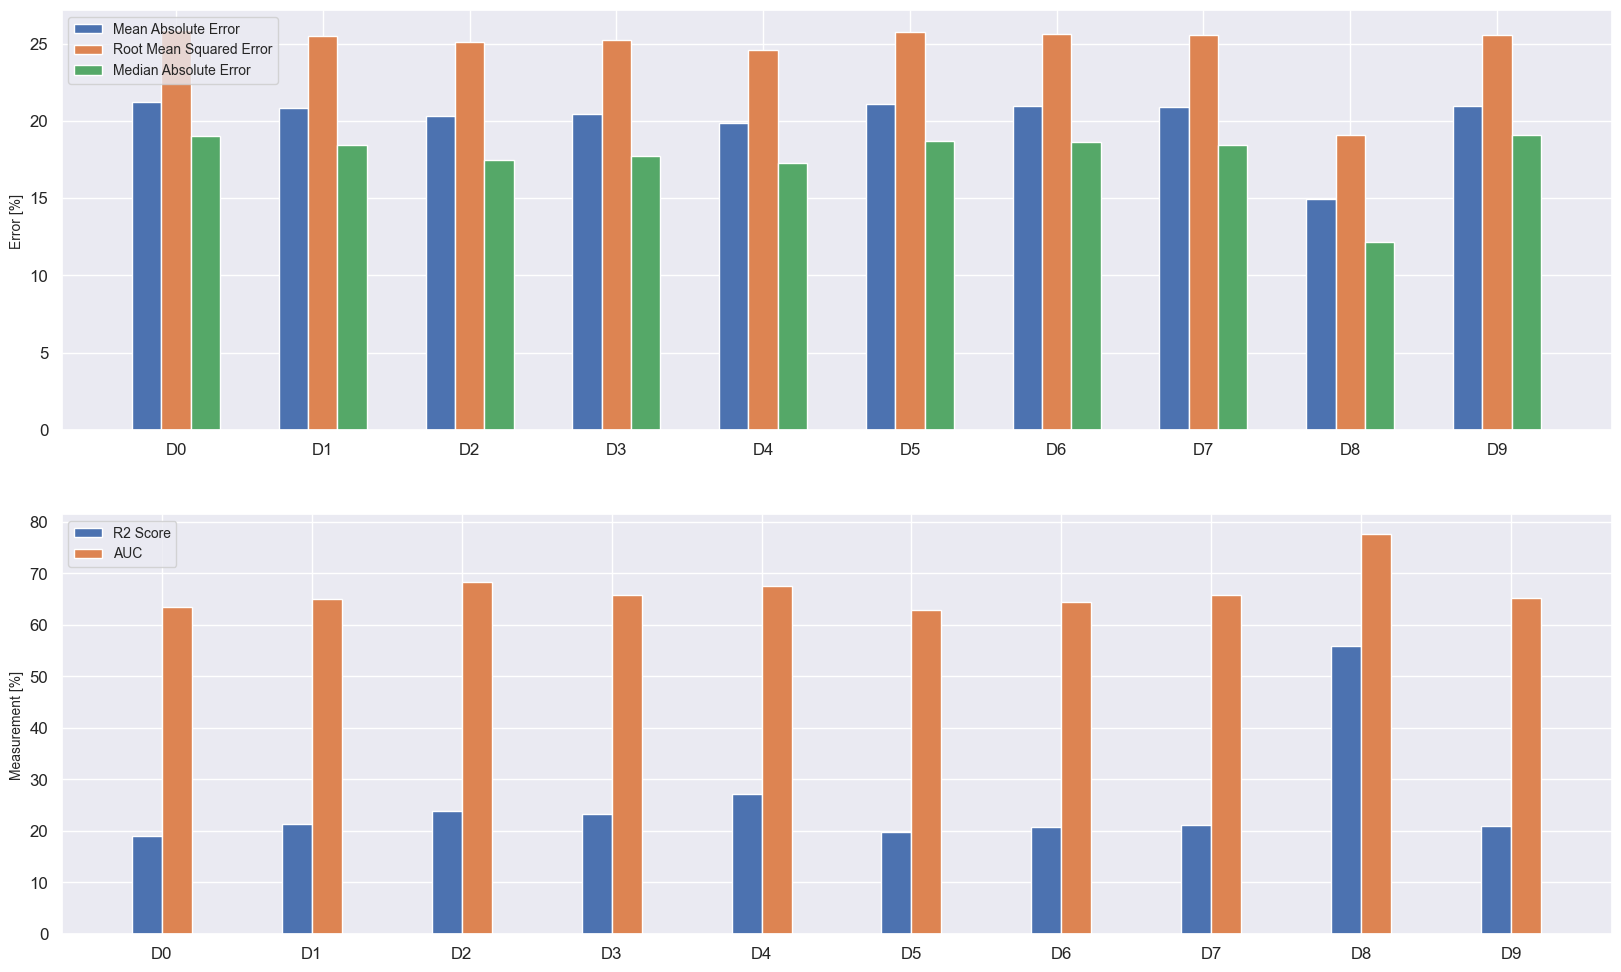

In [18]:
# -- PLOTTING THE RESULTS --
modelPlotResults([], lr_accuracy_train, lr_accuracy_test, lr_y_pred, lr_y_true, 
                 xlabel = "Slope", param_name = "Slope", fontsize = 10, 
                 save_path = "graphs/lr/lr", evolution_param = False)

[comment]: <> (Section)
<hr style="color:#c6cde1; width: 105px;" align="left">
<p style="color:#c6cde1;">Regression tree </p>
<hr style="color:#c6cde1; width: 105px;" align="left">

In [ ]:
# -- TRAINING AND TESTING --
#
# Definition of the parameters to be tested
dt_param = np.linspace(5, 20, 15, dtype = int)

# Stores the accuracy of the training and testing
dt_accuracy_train = [[] for i in range(len(datasets_X))]
dt_accuracy_test  = [[] for i in range(len(datasets_X))]
dt_y_pred = [[] for i in range(len(datasets_X))]
dt_y_true = [[] for i in range(len(datasets_X))]

for depth in dt_param:

    # Initialization of the model
    model = tree.DecisionTreeRegressor(max_depth = depth, random_state=4)

    # Computing accuracies on all the datasets
    acc_train, acc_test, n_y_pred, n_y_true = modelTesting(datasets_X, datasets_Y, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        dt_accuracy_train[i].append(acc_1)
        dt_accuracy_test[i].append(acc_2)

    for i, y_pred, y_true in zip(range(len(n_y_pred)), n_y_pred, n_y_true):
        dt_y_pred[i].append(y_pred)
        dt_y_true[i].append(y_true)

In [ ]:
# -- PLOTTING THE RESULTS --
modelPlotResults(dt_param, dt_accuracy_train, dt_accuracy_test, dt_y_pred, dt_y_true,
                 xlabel = "Depth of the tree - $d$ [-]", fontsize = 10, evolution_param = True,
                 param_name = "Depth", save_path = "graphs/dt/dt")

<hr style="color:#c6cde1; width: 155px;" align="left">
<p style="color:#c6cde1;">K-Neighbors-Regressor</p>
<hr style="color:#c6cde1; width: 155px;" align="left">

In [ ]:
# -- TRAINING AND TESTING --
#
# Definition of the parameters to be tested
k_param = np.arange(1, 100, 10, dtype = int)

# Stores the accuracy of the training and testing
knn_accuracy_train = [[] for i in range(len(datasets_X))]
knn_accuracy_test  = [[] for i in range(len(datasets_X))]
knn_y_pred = [[] for i in range(len(datasets_X))]
knn_y_true = [[] for i in range(len(datasets_X))]

for k in k_param:

    # Initialization of the model
    model = KNeighborsRegressor(n_neighbors = k)

    # Computing accuracies on all the datasets
    acc_train, acc_test, n_y_pred, n_y_true = modelTesting(datasets_X, datasets_Y, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        knn_accuracy_train[i].append(acc_1)
        knn_accuracy_test[i].append(acc_2)

    for i, y_pred, y_true in zip(range(len(n_y_pred)), n_y_pred, n_y_true):
        knn_y_pred[i].append(y_pred)
        knn_y_true[i].append(y_true)

In [ ]:
# -- PLOTTING THE RESULTS --
modelPlotResults(k_param, knn_accuracy_train, knn_accuracy_test, knn_y_pred, knn_y_true,
                 xlabel = "Number of k Neighbors - $k$ [-]", fontsize = 10, 
                 param_name = "knn", save_path = "graphs/knn/knn")

<hr style="color:#c6cde1; width: 225px;" align="left">
<p style="color:#c6cde1;">Linear Support Vector Regression</p>
<hr style="color:#c6cde1; width: 225px;" align="left">

In [ ]:
# -- TRAINING AND TESTING -- 
#
# Parameters to test for Grid Search
C_param = np.linspace(0.001, 1, num=20)

# Stores the accuracy of the training and testing
svr_accuracy_train = [[] for i in range(len(datasets_X))]
svr_accuracy_test  = [[] for i in range(len(datasets_X))]
svr_y_pred = [[] for i in range(len(datasets_X))]
svr_y_true = [[] for i in range(len(datasets_X))]

for c in C_param:

    # Initialization of the model
    model = LinearSVR(random_state=0, dual = False, loss = "squared_epsilon_insensitive", C = c, epsilon = 0.001)

    # Computing accuracies on all the datasets
    acc_train, acc_test, n_y_pred, n_y_true = modelTesting(datasets_X, datasets_Y, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        svr_accuracy_train[i].append(acc_1)
        svr_accuracy_test[i].append(acc_2)

    for i, y_pred, y_true in zip(range(len(n_y_pred)), n_y_pred, n_y_true):
        svr_y_pred[i].append(y_pred)
        svr_y_true[i].append(y_true)

# Rounding values of alpha for better display
C_param = [round(item, 3) for item in C_param]

In [ ]:
# -- PLOTTING THE RESULTS --
modelPlotResults(C_param, svr_accuracy_train, svr_accuracy_test, svr_y_pred, svr_y_true,
                 xlabel = "Regularization parameter - $C$ [-]", fontsize = 10, evolution_param = True,
                 param_name = "C", save_path = "graphs/svr/svr")

<hr style="color:#c6cde1; width: 115px;" align="left">
<p style="color:#c6cde1;">Ridge Regression</p>
<hr style="color:#c6cde1; width: 115px;" align="left">

In [ ]:
# -- TRAINING AND TESTING --
#
# Definition of the parameters to be tested
alpha_param = np.linspace(40, 0.01, 50)

# Stores the accuracy of the training and testing
rr_accuracy_train = [[] for i in range(len(datasets_X))]
rr_accuracy_test  = [[] for i in range(len(datasets_X))]
rr_y_pred = [[] for i in range(len(datasets_X))]
rr_y_true = [[] for i in range(len(datasets_X))]

for alpha in alpha_param:

    # Initialization of the model
    model = Ridge(alpha = alpha)

    # Computing accuracies on all the datasets
    acc_train, acc_test, n_y_pred, n_y_true = modelTesting(datasets_X, datasets_Y, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        rr_accuracy_train[i].append(acc_1)
        rr_accuracy_test[i].append(acc_2)

    for i, y_pred, y_true in zip(range(len(n_y_pred)), n_y_pred, n_y_true):
        rr_y_pred[i].append(y_pred)
        rr_y_true[i].append(y_true)

# Rounding values of alpha for better display
alpha_param = [round(item, 2) for item in alpha_param]

In [ ]:
# -- PLOTTING THE RESULTS --
modelPlotResults(alpha_param, rr_accuracy_train, rr_accuracy_test, rr_y_pred, rr_y_true,
                 xlabel = "Penalization - alpha [-]", fontsize = 10, 
                 param_name = "alpha", save_path = "graphs/rr/rr")

<hr style="color:#c6cde1; width: 102px;" align="left">
<p style="color:#c6cde1;">Random Forest</p>
<hr style="color:#c6cde1; width: 102px;" align="left">

In [ ]:
# -- TRAINING AND TESTING --
#
# Definition of the parameters to be tested
rf_max_depth = np.linspace(10, 30, 2, dtype = int)

# Stores the accuracy of the training and testing
rf_accuracy_train = [[] for i in range(len(datasets_X))]
rf_accuracy_test  = [[] for i in range(len(datasets_X))]
rf_y_pred = [[] for i in range(len(datasets_X))]
rf_y_true = [[] for i in range(len(datasets_X))]

for depth in rf_max_depth:

    # Initialization of the model
    model = RandomForestRegressor(max_depth = depth, n_estimators = 20, n_jobs = 4)

    # Computing accuracies on all the datasets
    acc_train, acc_test, n_y_pred, n_y_true = modelTesting(datasets_X, datasets_Y, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        rf_accuracy_train[i].append(acc_1)
        rf_accuracy_test[i].append(acc_2)

    for i, y_pred, y_true in zip(range(len(n_y_pred)), n_y_pred, n_y_true):
        rf_y_pred[i].append(y_pred)
        rf_y_true[i].append(y_true)

In [ ]:
# -- PLOTTING THE RESULTS --
modelPlotResults(rf_max_depth, rf_accuracy_train, rf_accuracy_test, rf_y_pred, rf_y_true,
                 xlabel = "Depth of the tree - $d$ [-]", fontsize = 10, 
                 param_name = "Depth", save_path = "graphs/rf/rf")

<hr style="color:#c6cde1; width: 155px;" align="left">
<p style="color:#c6cde1;">Extra Trees Regression</p>
<hr style="color:#c6cde1; width: 155px;" align="left">

In [ ]:
# -- TRAINING AND TESTING --
#
# Definition of the parameters to be tested
et_max_depth = np.linspace(10, 30, 2, dtype = int)

# Stores the accuracy of the training and testing
et_accuracy_train = [[] for i in range(len(datasets_X))]
et_accuracy_test  = [[] for i in range(len(datasets_X))]
et_y_pred = [[] for i in range(len(datasets_X))]
et_y_true = [[] for i in range(len(datasets_X))]

for depth in et_max_depth:

    # Initialization of the model
    model = ExtraTreesRegressor(max_depth = depth, n_estimators = 100, n_jobs = 4)

    # Computing accuracies on all the datasets
    acc_train, acc_test, n_y_pred, n_y_true = modelTesting(datasets_X, datasets_Y, model, test_size = 0.3, random_state = 69)

    # Adding the results
    for i, acc_1, acc_2 in zip(range(len(acc_train)), acc_train, acc_test):
        et_accuracy_train[i].append(acc_1)
        et_accuracy_test[i].append(acc_2)

    for i, y_pred, y_true in zip(range(len(n_y_pred)), n_y_pred, n_y_true):
        et_y_pred[i].append(y_pred)
        et_y_true[i].append(y_true)

In [ ]:
# -- PLOTTING THE RESULTS --
modelPlotResults(et_max_depth, et_accuracy_train, et_accuracy_test, et_y_pred, et_y_true,
                 xlabel = "Depth of the tree - $d$ [-]", fontsize = 10, 
                 param_name = "Depth", save_path = "graphs/et/et")

<hr style="color:#c6cde1; width: 155px;" align="left">
<p style="color:#c6cde1;">Multi-Layer-Perceptron</p>
<hr style="color:#c6cde1; width: 155px;" align="left">

In [ ]:
# -- PARAMETERS --
# 
# Number of epochs for the training
number_epochs = 2

# Learning rate
lr = 0.001

# Batch size
bs = 64

# Dimensional factor for the NN architecture
size_factor = 2

In [ ]:
# -- NEURAL NETWORK -- 
class MLP_PowerPrediction(nn.Module):

    # Initalization of the model
    def __init__(self, input_size, nn_size = 2):

        # Need to call the super to define child functions
        super(MLP_PowerPrediction, self).__init__()

        # Used to increase simply the size of the network
        size_factor = nn_size

        # Contains the fully connected layers
        self.fullyConnected_1 = nn.Linear(in_features = input_size,       out_features = 16 * size_factor).double()
        self.fullyConnected_2 = nn.Linear(in_features = 16 * size_factor, out_features = 32 * size_factor).double()
        self.fullyConnected_3 = nn.Linear(in_features = 32 * size_factor, out_features = 32 * size_factor).double()
        self.fullyConnected_4 = nn.Linear(in_features = 32 * size_factor, out_features = 16 * size_factor).double()
        self.fullyConnected_5 = nn.Linear(in_features = 16 * size_factor, out_features = 1).double()
    
    # Defining how data will flow through the network
    def forward(self, x):
        x = self.fullyConnected_1(x)
        x = F.relu(x)
        x = self.fullyConnected_2(x)
        x = F.relu(x)
        x = self.fullyConnected_3(x)
        x = F.relu(x)
        x = self.fullyConnected_4(x)
        x = F.relu(x)
        x = self.fullyConnected_5(x)
        return x

In [ ]:
# -- DATALOADER --
class PowerDataset(Dataset):
    def __init__(self, X, y):

            # Conversion to numpy and double type (needed for torch weight)
            X = X.to_numpy().astype(np.double)
            y = y["TARGETVAR"].to_numpy().astype(np.double)

            # Conversion to torch tensor
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)
        
    def __getitem__(self, index):
        return (self.X[index], self.y[index])
    
    def __len__(self):
        return self.X.shape[0]

    def getDatasets(self):
        return self.X, self.y


In [ ]:
# -- TRAINING & TESTING --
#
# Contains evolution of training and test lost over the epochs for each dataset
nn_accuracy_train_total, nn_accuracy_test_total, nn_y_pred_total, nn_y_true_total = list(), list(), list(), list()

# Used to compute R2 Metric
r2score = R2Score()

# Looping over all the datasets
for i, dataset_X, dataset_Y in zip(range(len(datasets_X)), datasets_X, datasets_Y):

    # Creation of train and test sets
    X_NN_train, X_NN_test, Y_NN_train, Y_NN_test = train_test_split(dataset_X, dataset_Y, test_size = 0.3)

    # Generation of the datasets
    POWER_loader_train   = DataLoader(PowerDataset(X_NN_train, Y_NN_train), batch_size = bs)
    X_NN_test, Y_NN_test = PowerDataset(X_NN_test,  Y_NN_test).getDatasets()

    # Number of inputs in current datasets
    nb_inputs =  len(dataset_X.to_numpy()[0])

    # Initalization of the network
    model_NN = MLP_PowerPrediction(nb_inputs, nn_size = size_factor) 

    # ---- Some stuff you don't need to look into ----
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_NN.parameters(), lr = 0.001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                               milestones = [int(number_epochs/2), int(number_epochs * 3/4), int(number_epochs * 7/8)], 
                                               gamma      = 0.1)

    # Used to compute training progression bar (1)
    size_train = len(X_NN_train)
    epoch_time = 0

    # Contains evolution of training and test lost over the epochs
    nn_accuracy_train, nn_accuracy_test, nn_y_pred, nn_y_true  = list(), list(), list(), list()

    # Display useful information over terminal (0)
    section(f"Neural Network - Training & Testing : Dataset ({i + 1}/{len(datasets_X)})")

    # Start training
    for epoch in range(number_epochs):

        # Used to compute loss
        epoch_loss_train  = 0.0
        epoch_steps_train = 0
        epoch_loss_test   = 0.0
        epoch_steps_test  = 0

        # Display useful information over terminal (1)
        print("Epoch : ", epoch + 1, "/", number_epochs)

        # Used to compute training progression bar (2)
        index = bs

        # Used to approximate time left for current epoch and in total
        start = time.time()

        #----------------------
        #       Training
        #----------------------
        # Retreiving a batch of data
        for x, y in POWER_loader_train:

            # Reseting gradients
            optimizer.zero_grad()

            # Computing prediction and storing target
            yhat  = model_NN.forward(x)
            ytrue = torch.unsqueeze(y, dim = 1)

            # Computing loss
            loss = criterion(yhat, ytrue)

            # Back-propagation
            loss.backward()

            # Optimization
            optimizer.step()

            # Updating epoch info ! Would be nice to upgrade it !
            epoch_loss_train   += loss.item()
            epoch_steps_train  += 1
            nb_epoch_left = number_epochs - epoch
            percentage    = (index/size_train) * 100 if (index/size_train) <= 1 else 100

            # Displaying information over terminal (2)
            progressBar(epoch_loss_train/epoch_steps_train, 0, 0, epoch_time, nb_epoch_left, percentage)
            index += bs

        # Updating the scheduler to update learning rate !
        scheduler.step()

        #----------------------
        #       Testing
        #----------------------
        with torch.no_grad():  

            # Computing prediction and storing target
            yhat  = model_NN.forward(X_NN_test)
            ytrue = torch.unsqueeze(Y_NN_test, dim = 1)

            # Computing loss
            loss_mse = criterion(yhat, ytrue)
            loss_r2  = r2score(yhat, ytrue)

            # Displaying information over terminal (2)
            progressBar(epoch_loss_train/epoch_steps_train, loss_mse.item(), loss_r2, epoch_time, nb_epoch_left, percentage)

        # Updating timing
        epoch_time    = time.time() - start

        # Updating training and test accuracies
        nn_accuracy_train.append(epoch_loss_train/epoch_steps_train)
        nn_accuracy_test.append(loss_mse)
        nn_y_pred.append(yhat.cpu().detach().numpy())
        nn_y_true.append(ytrue.cpu().detach().numpy())

        # Just to make sure there is no overlap between progress bar and section
        print("\n")
    
    # Updating training and test accuracies
    nn_accuracy_train_total.append(nn_accuracy_train)
    nn_accuracy_test_total.append(nn_accuracy_test)
    nn_y_pred_total.append(nn_y_pred)
    nn_y_true_total.append(nn_y_true)

In [ ]:
# -- PLOTTING THE RESULTS --
modelPlotResults(np.linspace(1, number_epochs, number_epochs), nn_accuracy_train_total, nn_accuracy_test_total, nn_y_pred_total, nn_y_true_total,
                 xlabel = "Number of epochs [-]", fontsize = 10, 
                 param_name = "Epoch", save_path = "graphs/nn/nn")

[comment]: <> (Section)
<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Ensemble Methods : Voting & Stacking Regressors
    </b>
</p>
<hr style="color:#c6cde1;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will try different ways to gather basic methods to improve the accuracy:
    <ul>
        <li style="margin-bottom:10px">Gather methods with the same accuracy inside a voting or stacking classifier;</li>
    </ul> 
</p>

In [ ]:
# -- FUNCTION --
#
def combine_methods(ensemble_method, methods_to_gather):
    #--------------
    # Documentation
    #--------------
    # - ensemble_method   : a string whose values may be either 'stacking' or 'voting'
    #
    # - methods_to_gather : A list with the methods to gather inside an ensemble regressor
    #
    if ensemble_method == 'stacking':
        model = StackingRegressor(estimators = methods_to_gather, final_estimator = LinearRegression(), n_jobs = 4)

    elif ensemble_method == 'voting':
        model = VotingRegressor(methods_to_gather, n_jobs = 4)

    return model

def pred_combine_methods(dataset_X, dataset_Y, first_model_name = 'RandomForest', ensemble_method  = 'voting', 
                         parameters = [{'n_estimators': [80], 'max_depth': [50]}], number_folds    = 5,
                         random_state = 69):
    #--------------
    # Documentation
    #--------------
    # - first_model_name : a string with the name of the tree regressor, can be either 
    #                      'RandomForest' or 'ExtraTreesRegressor'
    # - ensemble_method  : a string whose values may be either 'stacking' or 'voting'
    # - parameters       : a list of dictionary with the paramers for the GridSearch
    # - number_folds     : an integer indicating the number of folds for the GridSearch
    # - random_state     : an integer indacting the seed of random objects
    #
    # Security
    assert first_model_name in ["RandomForest", "ExtraTreesRegressor"], "First model = RandomForest or ExtraTreesRegressor"
    assert ensemble_method  in ["stacking", "voting"],                  "Ensemble method = voting or stacking"
    
    # Displaying information over terminal (1)
    print('Progression:...')

    # Stores all the results from the training session
    best_parameters, y_pred_zones, y_true_zones = list(), list(), list()

    # Looping over all the different zones
    for zone_ID in range(1, 11):
        
        # Used to have an idea of simulation time (1)
        start = time.time()

        # ============= Creation of the sets for the corresponding zone =============
        x  =  dataset_X[zone_ID - 1].to_numpy()
        y  =  dataset_Y[zone_ID - 1][["TARGETVAR"]].to_numpy().ravel()

        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = random_state)

        # ============== Creation of the combined model (1st layer) ==================
        r1 = ExtraTreesRegressor(random_state = random_state) if first_model_name == "ExtraTrees" else RandomForestRegressor(random_state = random_state)

        # Looking for best tree
        r1_best_model = GridSearchCV(r1, parameters, cv = number_folds, refit=True, 
                                     verbose = 0, n_jobs = 4, scoring = 'r2')
        
        # Fitting on training data
        r1_best_model.fit(X_train, y_train)

        # Retreiving best parameters
        best_parameters.append(r1_best_model.best_params_)

        # =========== Creation of the combined model (2nd layer & Training) ==========
        r2_best_model = KNeighborsRegressor(n_neighbors=2) 

        # Initialization of the combined model
        combined_model = combine_methods(ensemble_method, [('trees', r1_best_model), ('knn1', r2_best_model)])

        # Fitting on training data
        combined_model.fit(X_train, y_train)

        # ================================  Results ===================================
        # Storing results
        y_pred_zones += combined_model.predict(X_test).tolist()
        y_true_zones += y_test.tolist()

        # Computing R2 metric
        accuracy_per_zone = combined_model.score(X_test, y_test)

        # Used to have an idea of simulation time (2)
        end = time.time() - start

        # Displaying information over terminal (2)
        print(f"ZONE ID: {zone_ID} - Best parameters of the tree: {best_parameters[zone_ID-1]} \
              - Accuracy : {accuracy_per_zone} - Time left: {end * (10 - zone_ID)} [s]")

    # Displaying information over terminal (3)
    print('End')

    return y_pred_zones, y_true_zones, best_parameters

In [ ]:
# -- GENERATION OF THE SEPARATED DATASETS --
#
# Define the type of dataset
dataset_type = "separated"

# Normalization parameters
norm_parameters = ["standard", "column"]

# Intialization of the loader
loader = dataLoader(dataset_original_X, dataset_original_Y)

# Displaying information over terminal (1)
print("Generating : ...")

# Pipeline
loader.pipeline(useMeanVariance    = True, var_MV   = ["U10", "V10", "U100", "V100"], variance_MV  = True, window_MV = 24,
                useZonal           = False,
                usePastTime        = True, var_PT   = ["U10", "V10", "U100", "V100"], window_ZON = 2,
                useNormalize       = True, norm_type = norm_parameters[0], data_type = norm_parameters[1],
                useSpeedNorm       = True,
                useSpeedDirection  = False, SpeedDir_height  = "both",
                removing           = False)

# Finalization
loader.finalization(dataset_type = dataset_type)

# Creation of the train/test sets
X_sep, submit_X_sep, Y_sep, submit_Y_sep = loader.splitTrainTest()

# Displaying information over terminal (2)
print(f"Number     : {len(X_sep)}")
print("Generating : Done")

In [ ]:
# -- TRAINING AND TESTING --
#
# Stores all the results
y_pred_ensemble, y_true_ensemble = [], []

# Testing possible model combinations
for m in ["RandomForest", "ExtraTreesRegressor"]:
    for e in ["voting", "stacking"]:

        # Training and testing
        y_pred_zones, y_true_zones, _ = pred_combine_methods(X_sep, Y_sep, first_model_name = m, ensemble_method  = e, 
                                                            parameters = [{'n_estimators': [5], 'max_depth': [20]}], number_folds  = 2, random_state = 69)
        y_pred_ensemble.append(y_pred_zones)
        y_true_ensemble.append(y_true_zones)

In [ ]:
# Plotting final results
modelPlotResultsComplex(y_pred_ensemble, y_true_ensemble, ["RF - Voting", "RF - Stacking", "ET - Voting", "ET - Stacking"], 
                        fontsize = 15, save_path = f"graphs/ensemble/ensemble")

[comment]: <> (Section)
<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Model Complex - Training | Testing | Plotting results
    </b>
</p>
<hr style="color:#c6cde1;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Train and test complex model using the optimal datasets found previously;</li>
    </ul> 
</p>

In [ ]:
# -- POWER OF THE CROWD (CLASS) -- 
class PowerOfTheCrowd():

    # Initalization of the model
    def __init__(self, model_generalized, models_specialized):
        #--------------
        # Documentation
        #--------------
        # - model_generalized  : the model that has been trained on all the data
        # 
        # - models_specialized : a list containing the 10 models that have been trained separately, 
        #                        they should be ordered by increasing ID number.
        #
        self.model_gen = model_generalized
        self.model_spe = models_specialized
    
    # Defining how data will flow through the network
    def score(self, x, y_true, average = "unique", return_predict = False):
        #--------------
        # Documentation
        #--------------
        # - x       : the input sample in pandas format
        #
        # - average : determine if the average is computed between the model i and the generalized (unique) 
        #             or using all the models (all)
        # Security
        assert average in ["unique", "all"], "Average can either be set to two or all"
        
        # ---- Averaging over all predictions ----
        if average == "all":

            # Changing to numpy
            x      = x.to_numpy()
            y_true = y_true["TARGETVAR"].to_numpy()

            # ---- Generalized model predictions  ----
            y_gen = self.model_gen.predict(x)

            # Stores results
            y_pred = np.zeros((11, x.shape[0]))

            # Computing each separate models predictions
            for i, m in enumerate(self.model_spe):
                y_pred[i, :] = m.predict(x)                

            # Adding generalized models results
            y_pred[10, :] = y_gen[:]

            # Computing final score
            return np.mean(y_pred, axis = 0), y_true if return_predict else r2_score(y_true, np.mean(y_pred, axis = 0))

        # ---- Averaging of corresponding specialized models and generalized model ----
        if average == "unique":

            # Stores all the results
            y_pred       = np.empty((0))
            y_true_final = np.empty((0))

            # Looping over the different zones
            for zone_ID in range(1, 11):

                # Extracting sub datasets
                Xi = x[x["ZONEID"] == zone_ID].to_numpy()
                Yi = y_true["TARGETVAR"][y_true["ZONEID"] == zone_ID].to_numpy()

                # Security
                if len(Xi) == 0:
                    continue
                
                # ---- Generalized model predictions  ----
                y_gen = self.model_gen.predict(Xi)

                # ---- Specialized model predictions  ----
                y_spe = self.model_spe[zone_ID - 1].predict(Xi)

                # ---- Computing mean of the results ----
                y_mean = np.add(y_gen, y_spe)/2

                # ---- Concatenation of the results ----
                y_pred       = np.concatenate((y_pred, y_mean))
                y_true_final = np.concatenate((y_true_final, Yi))

            # Computing final score
            return y_pred, y_true_final if return_predict else r2_score(y_true_final, y_pred)        

In [ ]:
# -- FUNCTIONS --
#
# Used to retreive an empty model (to be used by grid search afterward)
def getModel(model_name = "knn"):
    if model_name == "rt":
        return DecisionTreeRegressor()
    if model_name == "knn":
        return KNeighborsRegressor()
    if model_name == "svr":
        return LinearSVR(dual = False, epsilon = 0.01, loss = 'squared_epsilon_insensitive', random_state = 69)
    if model_name == "rr":
        return Ridge()
    if model_name == "rf":
        return RandomForestRegressor(random_state = 69, n_jobs = 4)
    if model_name == "er":
        return ExtraTreesRegressor(random_state = 69, n_jobs = 4)

<hr style="color:#c6cde1;"></hr>


In [ ]:
# -- GENERATION OF THE DATASETS FOR THE COMPLEX MODELS --
#
# Note : Each pipeline will generate the optimal dataset for the method tested ! 
#
# Stores all the newly generated datasets
datasets_X_complex, datasets_X_submit_complex, datasets_Y_complex, datasets_Y_submit_complex = list(), list(), list(), list()

# Intialization of the loader
loader = dataLoader(dataset_original_X, dataset_original_Y)

# Displaying information over terminal (1)
print("Generating : ...")

# Regression tree
loader.pipeline(useMeanVariance    = False,
                useZonal           = False,
                usePastTime        = False,
                useNormalize       = True, norm_type = "standard", data_type = "all",
                useSpeedNorm       = True,
                useSpeedDirection  = False,
                removing           = False)
loader.finalization()
X, submit_X, Y, submit_Y = loader.splitTrainTest()
datasets_X_complex.append(X), datasets_X_submit_complex.append(submit_X), 
datasets_Y_complex.append(Y), datasets_Y_submit_complex.append(submit_Y)

# K-Nearest-Neighbors
loader.pipeline(useMeanVariance    = True, window_MV  = 12,
                useZonal           = False,
                usePastTime        = True, window_ZON = 3,
                useNormalize       = True, norm_type = "standard", data_type = "all",
                useSpeedNorm       = False,
                useSpeedDirection  = False,
                removing           = False)
loader.finalization()
X, submit_X, Y, submit_Y = loader.splitTrainTest()
datasets_X_complex.append(X), datasets_X_submit_complex.append(submit_X), 
datasets_Y_complex.append(Y), datasets_Y_submit_complex.append(submit_Y)

# Linear Support Vector Regression
loader.pipeline(useMeanVariance    = False,
                useZonal           = True,
                usePastTime        = False,
                useNormalize       = True, norm_type = "standard", data_type = "all",
                useSpeedNorm       = True,
                useSpeedDirection  = False,
                removing           = False)
loader.finalization()
X, submit_X, Y, submit_Y = loader.splitTrainTest()
datasets_X_complex.append(X), datasets_X_submit_complex.append(submit_X), 
datasets_Y_complex.append(Y), datasets_Y_submit_complex.append(submit_Y)

# Ridge Regression
loader.pipeline(useMeanVariance    = True, window_MV = 24,
                useZonal           = False,
                usePastTime        = False,
                useNormalize       = True, norm_type = "standard", data_type = "all",
                useSpeedNorm       = True,
                useSpeedDirection  = False,
                removing           = False)
loader.finalization()
X, submit_X, Y, submit_Y = loader.splitTrainTest()
datasets_X_complex.append(X), datasets_X_submit_complex.append(submit_X), 
datasets_Y_complex.append(Y), datasets_Y_submit_complex.append(submit_Y)

# RandomForestRegressor
loader.pipeline(useMeanVariance    = True,  window_MV  = 24,
                useZonal           = False,
                usePastTime        = False,
                useNormalize       = True, norm_type = "standard", data_type = "all",
                useSpeedNorm       = False,
                useSpeedDirection  = False,
                removing           = False)
loader.finalization()
X, submit_X, Y, submit_Y = loader.splitTrainTest()
datasets_X_complex.append(X), datasets_X_submit_complex.append(submit_X), 
datasets_Y_complex.append(Y), datasets_Y_submit_complex.append(submit_Y)

# ExtraTreesRegressor
loader.pipeline(useMeanVariance    = False,
                useZonal           = False,
                usePastTime        = False,
                useNormalize       = True, norm_type = "standard", data_type = "all",
                useSpeedNorm       = False,
                useSpeedDirection  = False,
                removing           = False)
loader.finalization()
X, submit_X, Y, submit_Y = loader.splitTrainTest()
datasets_X_complex.append(X), datasets_X_submit_complex.append(submit_X), 
datasets_Y_complex.append(Y), datasets_Y_submit_complex.append(submit_Y)

# Displaying information over terminal (2)
print(f"Number     : {len(datasets_X_complex)}")
print("Generating : Done")

In [ ]:
# -- PARAMETERS FOR TRAINING --
#
# Contains the list of models to test
model_complex_list = ["rt", "knn", "svr", "rr", "rf", "er"]

# Model (specialiez) parameters to be tested using a gridsearch
model_complex_parameters_specialized = [{"max_depth"   :[20]                         },
                                        {"n_neighbors" :[2]                          },
                                        {"C"           :[0.005]                      },
                                        {"alpha"       :[7.36]                       },
                                        {"max_depth"   :[60],  "n_estimators" : [100]},
                                        {"max_depth"   :[60],  "n_estimators" : [100]}
                                        ]

# Model (generalized) parameters to use
model_complex_parameters_generalized = [{"max_depth"   :[20]                         },
                                        {"n_neighbors" :[2]                          },
                                        {"C"           :[0.005]                      },
                                        {"alpha"       :[7.36]                       },
                                        {"max_depth"   :[60],  "n_estimators" : [100]},
                                        {"max_depth"   :[60],  "n_estimators" : [100]}
                                        ]
#------------
#  Security
#------------
assert len(model_complex_list) == len(datasets_X_complex),                   f"Number of datasets = {len(datasets_X_complex)}, Number of models           = {len(model_complex_list)}"
assert len(model_complex_list) == len(model_complex_parameters_specialized), f"Number of datasets = {len(datasets_X_complex)}, Number of parameters (spe) = {len(model_complex_parameters_specialized)}"
assert len(model_complex_list) == len(model_complex_parameters_generalized), f"Number of datasets = {len(datasets_X_complex)}, Number of parameters (gen) = {len(model_complex_parameters_generalized)}"

In [ ]:
# -- TRAINING AND TESTING THE COMPLEX MODELS --
#
# Stores all the complex models created
model_complex_trained = []

# Stores all the test sets for evaluation afterwards
X_test_complex = []
Y_test_complex = []

# Looping over model, their corresponding datasets and parameters
for X_set, Y_set, m, param_spe, param_gen in zip(datasets_X_complex, datasets_Y_complex, model_complex_list, model_complex_parameters_specialized, model_complex_parameters_generalized):

    # Displaying information over terminal (1)
    section(f"Model : {m}")

    # Stores all the individual models
    models_sep = []

    # Stores the train and test set of the generalized model (concatenation of the small one to avoid bias)
    X_train_generalized = pd.DataFrame()
    Y_train_generalized = pd.DataFrame()
    X_test_generalized  = pd.DataFrame()
    Y_test_generalized  = pd.DataFrame()

    # -------- Separated Models -------- 
    for zone_ID in range(1, 11):

        # Retreiving corresponding data
        Xi = copy.deepcopy(X_set[X_set["ZONEID"] == zone_ID])
        Yi = copy.deepcopy(Y_set[Y_set["ZONEID"] == zone_ID])

        # Creation of training and testing sets
        X_NN_train, X_NN_test, Y_NN_train, Y_NN_test = train_test_split(Xi, Yi, test_size = 0.3)

        # Adding datasets
        X_train_generalized  = pd.concat([X_train_generalized, X_NN_train], axis = 0)
        Y_train_generalized  = pd.concat([Y_train_generalized, Y_NN_train], axis = 0)
        X_test_generalized   = pd.concat([X_test_generalized,  X_NN_test] , axis = 0)
        Y_test_generalized   = pd.concat([Y_test_generalized,  Y_NN_test] , axis = 0)

        # Intialization of the model
        model = GridSearchCV(getModel(m), param_spe, n_jobs = 4)

        # Fitting the data
        model.fit(X_NN_train.to_numpy(), Y_NN_train["TARGETVAR"].to_numpy())

        # Storing the model
        models_sep.append(model)

        # Computing score
        score_spe = model.score(X_NN_test.to_numpy(), Y_NN_test["TARGETVAR"].to_numpy())

        # Displaying information over terminal (2)
        print(f"Zone {zone_ID}/10 - Best parameter value = {model.best_params_} - Accuracy = {score_spe}")

    # -------- Generalized Model --------
    #
    # Initialization of the model
    model_gen = GridSearchCV(getModel(m), param_gen)

    # Fitting the data
    model_gen.fit(X_train_generalized.to_numpy(), Y_train_generalized["TARGETVAR"].to_numpy())

    # Computing score
    score_gen = model.score(X_NN_test.to_numpy(), Y_NN_test["TARGETVAR"].to_numpy())

    # Displaying information over terminal (2)
    print(f"Zone ALL - Best parameter value = {model_gen.best_params_} - Accuracy = {score_gen}")

    # -------- Complex Model --------
    #
    # Intialization of the complex model
    model_final = PowerOfTheCrowd(model_gen, models_sep)

    # Stores all the complex models created
    model_complex_trained.append(model_final)
    X_test_complex.append(X_test_generalized)
    Y_test_complex.append(Y_test_generalized)

In [ ]:
# --- EVALUATION OF THE MODEL AND COMPARING RESULTS ---
#
# Determine if all the separated models are used for prediction or just the corresponding one
avg = "all"

# Stores the predicted and true results
y_predict_final = []
y_true_final    = []

# Testing all the models
for x, y, m in zip(X_test_complex, Y_test_complex, model_complex_trained):

    # Evaluation of the complex model
    y_pred, y_true = m.score(x, y, average = avg, return_predict = True)

    # Adding everything
    y_predict_final.append(y_pred)
    y_true_final.append(y_true)

# Definition of the labels
labels = ["RT", "KNN", "SVR", "RR", "RF", "ER"]

# Plotting final results
modelPlotResultsComplex(y_predict_final, y_true_final, labels, fontsize = 15, save_path = f"graphs/complex/complex_{avg}")

[comment]: <> (Section)
<hr style="color:#c6cde1;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#c6cde1;">
    Model complex - Neural Network
    </b>
</p>
<hr style="color:#c6cde1;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Create a complex model using a Neural Network</li>
    </ul> 
</p>

In [ ]:
# -- PARAMETERS --
# 
# Number of epochs for the training
number_epochs_c = 4

# Learning rate
lr_c = 0.001

# Batch size
bs_c = 64

In [ ]:
# -- GENERATION OF THE DATASETS FOR THE NEURAL NETWORK COMPLEX MODELS --
#
# Stores all the newly generated datasets
datasets_X_complex_NN, datasets_Y_complex_NN = list(), list()

# Intialization of the loader
loader = dataLoader(dataset_original_X, dataset_original_Y)

# Displaying information over terminal (1)
print("Generating : ...")

# Regression tree
loader.pipeline(useMeanVariance    = False,
                useZonal           = False,
                usePastTime        = False,
                useNormalize       = True, norm_type = "standard", data_type = "all",
                useSpeedNorm       = True,
                useSpeedDirection  = False,
                removing           = False)
loader.finalization()
X, _, Y, _ = loader.splitTrainTest()

# 1 - Adding separate datasets
for i in range(1, 11):
    datasets_X_complex_NN.append(copy.deepcopy(X[X["ZONEID"] == i]))
    datasets_Y_complex_NN.append(copy.deepcopy(Y[Y["ZONEID"] == i]))

# Displaying information over terminal (2)
print(f"Number     : {len(datasets_X_complex_NN)}")
print("Generating : Done")

In [ ]:
# -- TRAINING & TESTING THE COMPLEX MODEL --
#
# Stores the accuracy of the training and testing
nn_accuracy_train = [[] for i in range(len(datasets_X_complex_NN))]
nn_accuracy_test  = [[] for i in range(len(datasets_X_complex_NN))]
nn_y_pred         = [[] for i in range(len(datasets_X_complex_NN))]
nn_y_true         = [[] for i in range(len(datasets_X_complex_NN))]

# Stores all the models that have been created
model_generalized_NN  = 0
models_specialized_NN = []

# Stores the test sets
X_test_complex  = pd.DataFrame()
Y_test_complex  = pd.DataFrame()
X_train_complex = pd.DataFrame()
Y_train_complex = pd.DataFrame()

# Used to compute R2 score
rscore = R2Score()

# Looping over all the datasets
for i, dataset_X, dataset_Y in zip(range(len(datasets_X_complex_NN)), datasets_X_complex_NN, datasets_Y_complex_NN):
    
    # Creation of train and test sets
    X_NN_train, X_NN_test, Y_NN_train, Y_NN_test = train_test_split(dataset_X, dataset_Y, test_size = 0.3)

    # Storing the test sets except for the generalized one
    if i != len(datasets_X_complex_NN) - 1:
        X_test_complex  = pd.concat([X_test_complex, X_NN_test], axis=0)
        Y_test_complex  = pd.concat([Y_test_complex, Y_NN_test], axis=0)
        X_train_complex = pd.concat([X_train_complex, X_NN_train], axis=0)
        Y_train_complex = pd.concat([Y_train_complex, Y_NN_train], axis=0)
    else:
        X_NN_train = X_train_complex
        X_NN_test  = X_test_complex
        Y_NN_train = Y_train_complex
        Y_NN_test  = Y_test_complex
    
    # Generation of the datasets
    POWER_loader_train   = DataLoader(PowerDataset(X_NN_train, Y_NN_train), batch_size = bs_c)
    X_NN_test, Y_NN_test = PowerDataset(X_NN_test,  Y_NN_test).getDatasets()

    # Number of inputs in current datasets
    nb_inputs =  len(dataset_X.to_numpy()[0])

    # Initalization of the network
    model_NN = MLP_PowerPrediction(nb_inputs)

    # ---- Some stuff you don't need to look into ----
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_NN.parameters(), lr = lr_c)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                               milestones = [int(number_epochs_c/2), int(number_epochs_c * 3/4), int(number_epochs_c * 7/8)], 
                                               gamma      = 0.1)

    # Used to compute training progression bar (1)
    size_train = len(X_NN_train)
    epoch_time = 0

    # Display useful information over terminal (0)
    section(f"Neural Network - Training & Testing : Dataset ({i + 1}/{len(datasets_X_complex_NN)})")

    # Start training
    for epoch in range(number_epochs_c):

        # Used to compute loss
        epoch_loss_train  = 0.0
        r2_loss_train     = 0.0
        epoch_steps_train = 0
        epoch_loss_test   = 0.0
        epoch_steps_test  = 0

        # Display useful information over terminal (1)
        print("Epoch : ", epoch + 1, "/", number_epochs_c)

        # Used to compute training progression bar (2)
        index = bs_c

        # Used to approximate time left for current epoch and in total
        start = time.time()

        #----------------------
        #       Training
        #----------------------
        # Retreiving a batch of data
        for x, y in POWER_loader_train:

            # Reseting gradients
            optimizer.zero_grad()

            # Computing prediction and storing target
            yhat  = model_NN.forward(x)
            ytrue = torch.unsqueeze(y, dim = 1)

            # Computing loss
            loss = criterion(yhat, ytrue)

            # Back-propagation
            loss.backward()

            # Optimization
            optimizer.step()

            # Updating epoch info ! Would be nice to upgrade it !
            epoch_loss_train   += loss.item()
            r2_loss_train      += rscore(yhat, ytrue).detach().numpy()
            epoch_steps_train  += 1
            nb_epoch_left = number_epochs_c - epoch
            percentage    = (index/size_train) * 100 if (index/size_train) <= 1 else 100

            # Displaying information over terminal (2)
            progressBar(epoch_loss_train/epoch_steps_train, 0, r2_loss_train/epoch_steps_train, epoch_time, nb_epoch_left, percentage)
            index += bs

        # Updating the scheduler to update learning rate !
        scheduler.step()

        #----------------------
        #       Testing
        #----------------------
        with torch.no_grad():  

            # Computing prediction and storing target
            yhat  = model_NN.forward(X_NN_test)
            ytrue = torch.unsqueeze(Y_NN_test, dim = 1)

            # Computing loss
            loss_mse = criterion(yhat, ytrue)
            
            # Adding preditions for AUC and R2 computation
            nn_y_pred[i].append(np.asarray([y[0] for y in yhat.detach().numpy()]))
            nn_y_true[i].append(np.asarray([y[0] for y in ytrue.detach().numpy()]))

            # Displaying information over terminal (2)
            progressBar(epoch_loss_train/epoch_steps_train, loss_mse.item(), rscore(yhat, ytrue), epoch_time, nb_epoch_left, percentage)

        # Updating timing
        epoch_time    = time.time() - start

        # Updating training and test accuracies
        nn_accuracy_train[i].append(r2_loss_train/epoch_steps_train)
        nn_accuracy_test[i].append(rscore(yhat, ytrue))

        # Just to make sure there is no overlap between progress bar and section
        print("\n")

        # Storing the models
        if i == len(datasets_X_complex_NN) - 1:
            model_generalized_NN  = model_NN
        else:
            models_specialized_NN.append(model_NN)

In [ ]:
# -- POWER OF THE CROWD (Neural Network Version) -- 
class PowerOfTheCrowdNN():

    # Initalization of the model
    def __init__(self, model_generalized, models_specialized):
        #--------------
        # Documentation
        #--------------
        # - model_generalized  : the model that has been trained on all the data
        # 
        # - models_specialized : a list containing the 10 models that have been trained separately, 
        #                        they should be ordered by increasing ID number.
        #
        self.model_gen = model_generalized
        self.model_spe = models_specialized
    
    # Defining how data will flow through the network
    def score(self, x, y_true, average = "unique", return_predict = False):
        #--------------
        # Documentation
        #--------------
        # - x       : the input sample in pandas format
        #
        # - average : determine if the average is computed between the model i and the generalized (unique) 
        #             or using all the models (all)
        # Security
        assert average in ["unique", "all"], "Average can either be set to two or all"
        
        # ---- Averaging over all predictions ----
        if average == "all":

            # Changing to numpy
            x         = torch.from_numpy(x.to_numpy())
            y_true_np = y_true["TARGETVAR"].to_numpy()
            y_true    = torch.from_numpy(y_true_np)

            # ---- Generalized model predictions  ----
            y_gen = np.squeeze(self.model_gen.forward(x).detach().numpy(), axis = 1)    

            # Stores results
            y_pred = np.zeros((11, x.shape[0]))

            # Computing each separate models predictions
            for i, m in enumerate(self.model_spe):
                y_pred[i, :] = np.squeeze(m.forward(x).detach().numpy(), axis = 1)                

            # Adding generalized models results
            y_pred[10, :] = y_gen[:]

            # Computing final score
            return np.mean(y_pred, axis = 0), y_true_np if return_predict else r2_score(y_true_np, np.mean(y_pred, axis = 0))

        # ---- Averaging of corresponding specialized models and generalized model ----
        if average == "unique":

            # Stores all the results
            y_pred       = np.empty((0))
            y_true_final = np.empty((0))

            # Looping over the different zones
            for zone_ID in range(1, 11):

                # Extracting sub datasets
                Xi    = torch.from_numpy(x[x["ZONEID"] == zone_ID].to_numpy())
                Yi_np = y_true["TARGETVAR"][y_true["ZONEID"] == zone_ID].to_numpy()
                Yi    =  torch.from_numpy(Yi_np)

                # Security
                if len(Xi) == 0:
                    continue
                
                # ---- Generalized model predictions  ----
                y_gen = np.squeeze(self.model_gen.forward(Xi).detach().numpy(), axis = 1)

                # ---- Specialized model predictions  ----
                y_spe = np.squeeze(self.model_spe[zone_ID - 1].forward(Xi).detach().numpy(), axis = 1)

                # ---- Computing mean of the results ----
                y_mean = np.add(y_gen, y_spe)/2

                # ---- Concatenation of the results ----
                y_pred       = np.concatenate((y_pred, y_mean))
                y_true_final = np.concatenate((y_true_final, Yi_np))

            # Computing final score
            return y_pred, y_true_final if return_predict else r2_score(y_true_final, y_pred)        

In [ ]:
# -- EVALUATION OF THE MODEL AND COMPARING RESULTS --
#
# Determine if all the separated models are used for prediction or just the corresponding one
avg = "unique"

# Creation of the complex model
model_complex_NN = PowerOfTheCrowdNN(model_generalized_NN, models_specialized_NN)

# Computing predictions
y_pred, y_true = model_complex_NN.score(X_test_complex, Y_test_complex, average = avg, return_predict = True)

print("R2 Metric:", r2_score(y_true, y_pred))

# Plotting final results
modelPlotResultsComplex([y_pred], [y_true], ["Comple Neural Network"], fontsize = 15, save_path = f"graphs/complex_nn/complex_nn_{avg}")
